In [1]:
#pip install imageio

In [1]:
##This is a framework of patch-based hyperspectral classification
import os
import time
import random
import spectral
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.patches as mpts
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from sklearn.preprocessing import minmax_scale
from scipy.io import loadmat
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
##hypeperameters and experimental settings
RANDOM_SEED=666
MODEL_NAME = '3DConvKAN' ## your model name
DATASET = 'Pingan'  ## PU  IP  SA or your personal dataset
TRAIN_RATE = 0.3  ## ratio of training data
VAL_RATE = 0.2    ## ratio of valuating data
EPOCH = 5    ##number of epoch
VAL_EPOCH = 1  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 64
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components   0:use origin data
NORM = True  ## normalization or not
PATCH_SIZE = 8 ## patchsize of input 3D cube   1:only spectral sequence
CHECK_POINT = None  ## path of check point model

SAVE_PATH = f"E:/Roy/Sim Pool/Results\\{MODEL_NAME}\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [3]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def loadData(name): ## customize data and return data label and class_name
    data_path = os.path.join(os.getcwd(),'E:/Roy/Sim Pool/Data/')
    if name == 'Tangdaowan':
        data = loadmat(os.path.join(data_path, 'QUH-Tangdaowan.mat'))['Tangdaowan']
        labels = loadmat(os.path.join(data_path, 'QUH-Tangdaowan_GT.mat'))['TangdaowanGT']
        class_name = [     "Rubber track",    "Flaggingv",    "Sandy",    "Asphalt",    "Boardwalk",    "Rocky shallows",    "Grassland",
    "Bulrush",    "Gravel road",    "Ligustrum vicaryi",    "Coniferous pine",    "Spiraea",    "Bare soil",    "Buxus sinica",    "Photinia serrulata",
    "Populus",    "Ulmus pumila L",    "Seawater"]
    
    elif name == 'Qingyun':
        data = loadmat(os.path.join(data_path, 'QUH-Qingyun.mat'))['Chengqu']
        labels = loadmat(os.path.join(data_path, 'QUH-Qingyun_GT.mat'))['ChengquGT']
        class_name = ["Trees", "Concrete building", "Car", "Ironhide building", "Plastic playground", "Asphalt road"]
    
    elif name == 'Pingan':
        data = loadmat(os.path.join(data_path, 'QUH-Pingan.mat'))['Haigang']
        labels = loadmat(os.path.join(data_path, 'QUH-Pingan_GT.mat'))['HaigangGT']
        class_name = ["Ship", "Seawater", "Trees"," Concrete structure building", "Floating pier", "Brick houses", 
                      "Steel houses"," Wharf construction land", "Car", "Road"]
    return data, labels, class_name


In [5]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

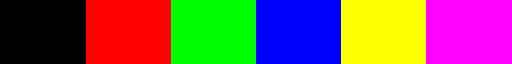

In [6]:
a = data[:,:,[1,2,3]]
cmap=plt.matplotlib.colors.ListedColormap(spectral.spy_colors/255,'Classification',6)
cmap

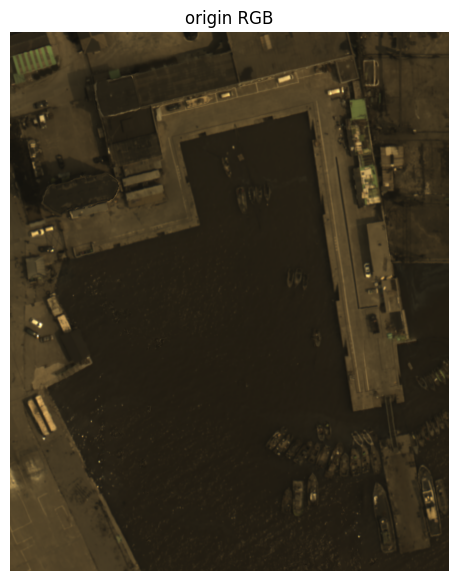

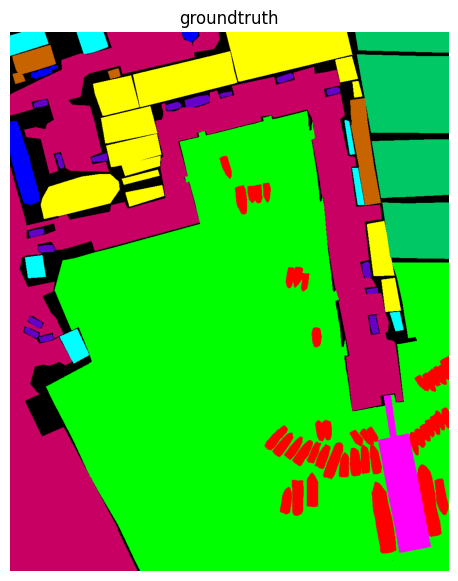

In [7]:
def img_display(data = None, rgb_band = None, classes = None,class_name = None,title = None, 
                figsize = (7,7),palette = spectral.spy_colors):
    if data is not None:
        im_rgb = np.zeros_like(data[:,:,0:3])
        im_rgb = data[:,:,rgb_band]
        im_rgb = im_rgb/(np.max(np.max(im_rgb,axis = 1),axis = 0))*255
        im_rgb = np.asarray(im_rgb,np.uint8)
        fig, rgbax = plt.subplots(figsize = figsize)
        rgbax.imshow(im_rgb)
        rgbax.set_title(title)
        rgbax.axis('off')
        
    elif classes is not None:
        rgb_class = np.zeros((classes.shape[0],classes.shape[1],3))
        for i in np.unique(classes):
            rgb_class[classes==i]=palette[i]
        rgb_class = np.asarray(rgb_class, np.uint8)
        _,classax = plt.subplots(figsize = figsize)
        classax.imshow(rgb_class)
        classax.set_title(title)
        classax.axis('off')
        # rect = [mpts.Rectangle((0,0),1,1,facecolor=palette[i]/255) for i in range(len(class_name))]
        # classax.legend(rect,class_name,bbox_to_anchor = (1.04,1),frameon=False,loc = 'upper left')
        
img_display(data,(30,20,10),title='origin RGB')
img_display(classes=label,title='groundtruth',class_name=class_name)

In [8]:
# ## display HSI
# rgb_view=spectral.imshow(data,(30,20,10),classes=label.astype(int),title='RGB origin',figsize=(7,7))
# gt_view = spectral.imshow(classes=label.astype(int), title='GroundTruth',figsize=(7,7))
# view = spectral.imshow(data,(30,20,10),classes=label.astype(int),figsize=(7,7))
# view.set_display_mode('overlay')
# view.set_title('Overlay')
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [9]:
def applyPCA(X, numComponents=15, norm = True):
    """PCA and processing
    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional):  number of reserved components(Defaults to 15, 0 for no PCA).
        norm: normalization or not
    Returns:
        newX: processed data
        pca: 
    """
    
    if numComponents == 0:
        newX = np.reshape(X, (-1, X.shape[2]))
    else:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents)   ##PCA and normalization
        newX = pca.fit_transform(newX)
    if norm:
        newX = minmax_scale(newX, axis=1)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], -1))
    return newX, newX.shape[2]

In [10]:
data,N_PCA = applyPCA(data, N_PCA, NORM)
data.shape,N_PCA

((1230, 1000, 15), 15)

In [11]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [12]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

          class          train_num  val_num   test_num   total   
          Ship             14680      9787     24468     48935   
        Seawater           173434    115622    289057    578113  
          Trees             2504      1669      4172      8345   
 Concrete structure building  26692     17794     44487     88973   
      Floating pier         6228      4152     10379     20759   
      Brick houses          4226      2817      7043     14086   
      Steel houses          4197      2798      6996     13991   
 Wharf construction land   24934     16623     41556     83113   
           Car              2432      1622      4054      8108   
          Road             82954     55303     138257    276514  
          total            342281    228187    570469   1140937  


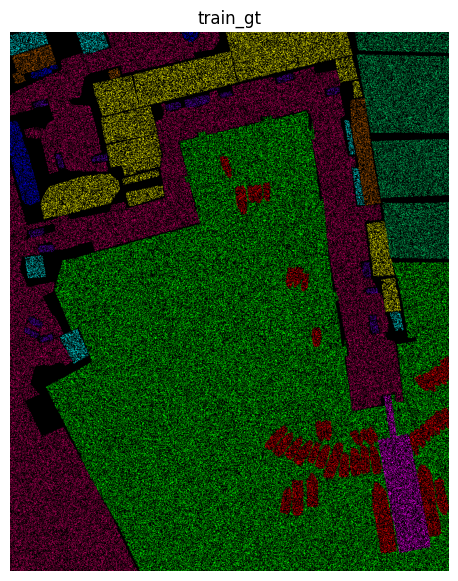

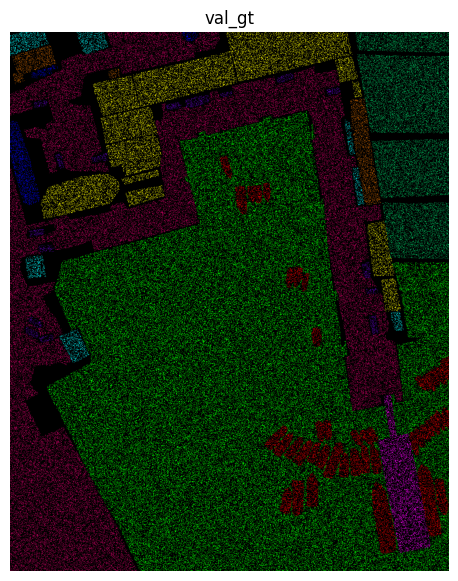

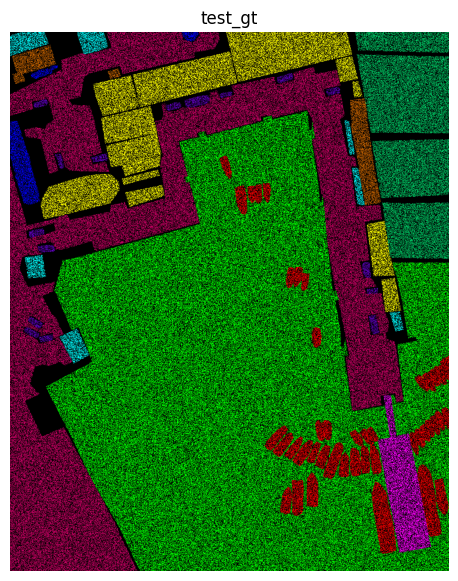

In [13]:
## display sampling info
sample_report = f"{'class': ^25}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{class_name[i-1]: ^25}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^25}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
img_display(classes=train_gt,title='train_gt')
img_display(classes=val_gt,title='val_gt')
img_display(classes=test_gt,title='test_gt')

# spectral.imshow(classes=train_gt, title='train_gt')
# spectral.imshow(classes=val_gt, title='val_gt')
# spectral.imshow(classes=test_gt, title='test_gt')

In [14]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        data = torch.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [15]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [16]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 8, 8, 1]), tensor(2))

In [17]:
#pip install unfoldNd

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from ConvKAN import ConvKAN
from ConvKAN3D import effConvKAN3D


In [19]:
in_chs=15
patch_size=8


class Net(nn.Module):
    # Define the architecture of the network
    def __init__(self):
        super(Net, self).__init__()
        
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.ConvKAN1 = effConvKAN3D(in_channels=15, out_channels=8, kernel_size=1)
        self.ConvKAN2 = effConvKAN3D(in_channels=8, out_channels=16, kernel_size=1)
        self.ConvKAN3 = effConvKAN3D(in_channels=16, out_channels=1, kernel_size=1)
        
        # 5*5 from image dimension
        self.KAN1 = nn.Linear(4 * 4 * 4 , 256)
        self.KAN2 = nn.Linear(256 , 128)
        self.KAN3 = nn.Linear(128, NUM_CLASS)

    # Set the flow of data through the network for the forward pass
    # x represents the data
    def forward(self, x):
        # F.relu is the rectified-linear activation function
        
        x = self.ConvKAN1(x)
        x = self.ConvKAN2(x)
        x = self.ConvKAN3(x)
        
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        x = self.KAN1(x)
        x = self.KAN2(x)
        x = self.KAN3(x)
        output = F.log_softmax(x, dim=1)
        
        return output

In [20]:
#instantiate CNN model
model = Net()
model

Net(
  (ConvKAN1): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN2): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN3): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (KAN1): Linear(in_features=64, out_features=256, bias=True)
  (KAN2): Linear(in_features=256, out_features=128, bias=True)
  (KAN3): Linear(in_features=128, out_features=10, bias=True)
)

In [21]:
torch.cuda.is_available()

True

In [22]:
from torchsummary import summary
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
summary(model.to(device),(15, 8,8,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          UnfoldNd-1               [-1, 15, 64]               0
              SiLU-2                   [-1, 15]               0
         KANLinear-3                    [-1, 8]               0
      effConvKAN3D-4           [-1, 8, 8, 8, 1]               0
          UnfoldNd-5                [-1, 8, 64]               0
              SiLU-6                    [-1, 8]               0
         KANLinear-7                   [-1, 16]               0
      effConvKAN3D-8          [-1, 16, 8, 8, 1]               0
          UnfoldNd-9               [-1, 16, 64]               0
             SiLU-10                   [-1, 16]               0
        KANLinear-11                    [-1, 1]               0
     effConvKAN3D-12           [-1, 1, 8, 8, 1]               0
           Linear-13                  [-1, 256]          16,640
           Linear-14                  [

In [22]:
#PATH = 'E:/Roy/Sim Pool/Results/Training/3D2DConvKAN_Tangdaowan_30.pth'
#model.load_state_dict(torch.load(PATH))
#moel=torch.load(PATH)

In [23]:
EPOCH=100


## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')

loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
epoch_start = 0

model = model ##modify to you model 
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)


if CHECK_POINT is not None:
    
    model_ckpt = torch.load(CHECK_POINT,map_location = device)
    model.load_state_dict(model_ckpt['state_dict'])
    epoch_start = model_ckpt['epoch']
    optimizer.load_state_dict(model_ckpt['optimizer'])
    loss_list = model_ckpt['loss_list']
    acc_list = model_ckpt['acc_list']
    val_acc_list = model_ckpt['val_acc_list']
    val_epoch_list = model_ckpt['val_epoch_list']

loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()
train_st = time.time()
run_error = False

try:
    for e in tqdm(range(epoch_start,EPOCH), desc="Training:"):
        
        model.train()
        avg_loss = 0.
        train_acc = 0
        
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            
            val_acc =0
            model.eval()
            
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            save_dict = {'state_dict':model.state_dict(), 'epoch':e+1, 'optimizer': optimizer.state_dict(),
                        'loss_list':loss_list, 'acc_list': acc_list, 'val_acc_list': val_acc_list, 'val_epoch_list':val_epoch_list}
            torch.save(save_dict,save_name)
except Exception as exc:
    print(exc)
    run_error = True
finally: 
    print(f'Stop in epoch {e}')
train_time = time.time()-train_st
print(f"training time: {train_time}")

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 0/100 loss:0.008365128481389938  acc:0.8220876998723271


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 0/100  val_acc:0.8480632113135279


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 1/100 loss:0.00671532902967592  acc:0.8559516888170831


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 1/100  val_acc:0.8653341338463628


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 2/100 loss:0.00614828022691222  acc:0.8690461930402213


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 2/100  val_acc:0.8740024628922769


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 3/100 loss:0.0058075498740865995  acc:0.8746848349747722


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 3/100  val_acc:0.8801377817316499


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 4/100 loss:0.005527396141729343  acc:0.8798560247282203


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.8822676138430322


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 5/100 loss:0.005295998362185713  acc:0.8843348009384102


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 5/100  val_acc:0.8888192578893627


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 6/100 loss:0.005063024990243383  acc:0.8894183434079017


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 6/100  val_acc:0.8899236152804498


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 7/100 loss:0.004880465477930774  acc:0.8930323330830516


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 7/100  val_acc:0.8936223360664718


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 8/100 loss:0.004703071578977043  acc:0.8965411460174535


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 8/100  val_acc:0.8902040869988211


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 9/100 loss:0.004565284521735141  acc:0.8992027018736067


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.9012520432802921


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 10/100 loss:0.004450167733052666  acc:0.9011660010342379


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 10/100  val_acc:0.9005245697607663


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 11/100 loss:0.0043467858861492795  acc:0.9033688694376842


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 11/100  val_acc:0.9024615775657684


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 12/100 loss:0.004222771783070285  acc:0.9057996207794181


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 12/100  val_acc:0.9038332595634282


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 13/100 loss:0.004154938340809535  acc:0.9074035660758266


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 13/100  val_acc:0.9080403353389983


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 14/100 loss:0.004077595428036902  acc:0.9090863939277962


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.9047667045011328


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 15/100 loss:0.00399649849070632  acc:0.9108510259114587


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 15/100  val_acc:0.9110203473466937


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 16/100 loss:0.003920469695225374  acc:0.9120284210926111


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 16/100  val_acc:0.909109633765289


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 17/100 loss:0.0038309947674965  acc:0.9143978193355752


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 17/100  val_acc:0.9094207820778571


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 18/100 loss:0.0037829282140228442  acc:0.9158381563685978


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 18/100  val_acc:0.909569782678242


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 19/100 loss:0.0037085258654016317  acc:0.9169220611135295


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 19/100  val_acc:0.9138119174186085


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 20/100 loss:0.003650766728940536  acc:0.9179183185745046


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 20/100  val_acc:0.914491184861539


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 21/100 loss:0.00359821178380691  acc:0.9193498908791314


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 21/100  val_acc:0.915205511269266


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 22/100 loss:0.003558649336943595  acc:0.9201007359450276


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 22/100  val_acc:0.9127338542511186


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 23/100 loss:0.0035096025855406773  acc:0.921035640307233


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 23/100  val_acc:0.9172126370038609


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 24/100 loss:0.0034604549378812383  acc:0.9222130354883853


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 24/100  val_acc:0.9138995648305994


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 25/100 loss:0.003405871849241498  acc:0.923057370990502


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 25/100  val_acc:0.9193512338564424


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 26/100 loss:0.0033591189165877926  acc:0.924082844212796


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 26/100  val_acc:0.9159329847887917


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 27/100 loss:0.0033258218057048705  acc:0.925321592492718


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 27/100  val_acc:0.9205914447361155


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 28/100 loss:0.003301358676963801  acc:0.9259555745133384


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 28/100  val_acc:0.9198595888459904


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 29/100 loss:0.003249473965131064  acc:0.9271183618138313


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.921007769943073


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 30/100 loss:0.0032178765960368203  acc:0.9274192841554162


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 30/100  val_acc:0.9168708120970958


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 31/100 loss:0.003187895861519945  acc:0.928365874822149


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 31/100  val_acc:0.9179532576351852


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 32/100 loss:0.0031558359391748816  acc:0.9290758178221987


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 32/100  val_acc:0.9199735304815787


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 33/100 loss:0.0031278638235772344  acc:0.9292540339662441


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 33/100  val_acc:0.9242507241867416


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 34/100 loss:0.0030848206888898205  acc:0.9307002141515305


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 34/100  val_acc:0.9226380118061064


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 35/100 loss:0.003062554265705924  acc:0.9310741758964126


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 35/100  val_acc:0.9157839841884069


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 36/100 loss:0.0030377254337499884  acc:0.9315796085672299


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 36/100  val_acc:0.9228483655948849


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 37/100 loss:0.0030006522088343503  acc:0.9327540821722503


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 37/100  val_acc:0.9217264787213996


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 38/100 loss:0.002964522810346666  acc:0.933244906962408


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 38/100  val_acc:0.9209288872722811


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 39/100 loss:0.0029373898806489464  acc:0.9337561827854891


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 39/100  val_acc:0.9235758391144105


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 40/100 loss:0.0029239133589101423  acc:0.9344193805674286


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 40/100  val_acc:0.9250921393418556


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 41/100 loss:0.002906349185527805  acc:0.93513224514361


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 41/100  val_acc:0.9240140761743657


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 42/100 loss:0.0028636063236773326  acc:0.9358451097197916


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 42/100  val_acc:0.9265427040103074


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 43/100 loss:0.002855842552517659  acc:0.9360905221148705


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 43/100  val_acc:0.9259554663499674


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 44/100 loss:0.0028210795704059557  acc:0.9368179945717116


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.9260036724265625


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 45/100 loss:0.0027855647625393207  acc:0.9375951338227947


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 45/100  val_acc:0.9255566706254081


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 46/100 loss:0.0027662497323231432  acc:0.9379749387199406


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 46/100  val_acc:0.9269590292172648


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 47/100 loss:0.002743694452281651  acc:0.9385125087282087


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 47/100  val_acc:0.9220551565163659


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 48/100 loss:0.002715799560926811  acc:0.9391640202056205


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 48/100  val_acc:0.9285103884095063


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 49/100 loss:0.002696437724577443  acc:0.939096823954587


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 49/100  val_acc:0.9257582596729875


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 50/100 loss:0.0026757001125876194  acc:0.9397804727694496


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 50/100  val_acc:0.9237467515677931


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 51/100 loss:0.0026554227368381193  acc:0.9403706311480917


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 51/100  val_acc:0.9258108481201821


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 52/100 loss:0.002636673002541364  acc:0.9407533576213696


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 52/100  val_acc:0.924618843317104


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 53/100 loss:0.0026097722170783364  acc:0.9413785749135943


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 53/100  val_acc:0.9267924991344818


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 54/100 loss:0.0025959347863886975  acc:0.9420680668807208


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.9313589292992152


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 55/100 loss:0.0025769570362995553  acc:0.9422813419383489


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 55/100  val_acc:0.9303159250965217


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 56/100 loss:0.002550467775016085  acc:0.9423660676461738


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 56/100  val_acc:0.9250088743004641


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 57/100 loss:0.0025520364737160075  acc:0.942737107814924


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 57/100  val_acc:0.931341399816817


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 58/100 loss:0.0025250400510449587  acc:0.9433681682594126


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 58/100  val_acc:0.9319111079947587


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 59/100 loss:0.0025069052756552654  acc:0.9434061487491272


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 59/100  val_acc:0.9284621823329111


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 60/100 loss:0.0024769753818886585  acc:0.9445134261031141


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 60/100  val_acc:0.9315210770113985


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 61/100 loss:0.002465099621837647  acc:0.9449282899138427


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 61/100  val_acc:0.9310696928396447


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 62/100 loss:0.002461255277397052  acc:0.9445660144734882


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 62/100  val_acc:0.9276602085131931


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 63/100 loss:0.0024423587191893864  acc:0.9450685255681736


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 63/100  val_acc:0.9282825051383296


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 64/100 loss:0.0024110763726517674  acc:0.9459333121032134


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.9317007542059802


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 65/100 loss:0.002411681658958116  acc:0.9456411544900243


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 65/100  val_acc:0.9273402954594259


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 66/100 loss:0.002385041119371726  acc:0.9463364896094145


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 66/100  val_acc:0.9309601335746559


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 67/100 loss:0.002381330576288331  acc:0.9464971762966685


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 67/100  val_acc:0.9295709220945979


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 68/100 loss:0.00235917376107075  acc:0.9470931778275744


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 68/100  val_acc:0.931849754806365


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 69/100 loss:0.002356462545060061  acc:0.9468740596176826


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 69/100  val_acc:0.9308330448272688


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 70/100 loss:0.0023410253227388305  acc:0.9473941001691593


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 70/100  val_acc:0.9294964217944055


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 71/100 loss:0.0023261809264165417  acc:0.9475927673461279


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 71/100  val_acc:0.9333704374044095


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 72/100 loss:0.00229631977860803  acc:0.9484546323050359


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 72/100  val_acc:0.9284446528505129


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 73/100 loss:0.0023028670437621477  acc:0.9482267493667483


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 73/100  val_acc:0.929119537922844


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 74/100 loss:0.0022890020990031104  acc:0.9481478668111873


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.932436992466705


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 75/100 loss:0.0022732027046878443  acc:0.9488081430169948


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 75/100  val_acc:0.9312406052930272


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 76/100 loss:0.002268036276837675  acc:0.9489191629100067


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 76/100  val_acc:0.9299083646307633


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 77/100 loss:0.0022522153764483223  acc:0.9495823606919461


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 77/100  val_acc:0.9324895809138996


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 78/100 loss:0.0022279396634196868  acc:0.9498102436302336


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 78/100  val_acc:0.9323756392783112


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 79/100 loss:0.0022348849101584884  acc:0.9498482241199482


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 79/100  val_acc:0.9323055213487184


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 80/100 loss:0.0022163831519714386  acc:0.9500205971117298


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 80/100  val_acc:0.9257582596729875


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 81/100 loss:0.0022114418799715476  acc:0.9500264402639936


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 81/100  val_acc:0.9336859680875773


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 82/100 loss:0.0022029711251201995  acc:0.9505727750006574


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 82/100  val_acc:0.932143373636535


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 83/100 loss:0.0021930835511823703  acc:0.9504851277167006


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 83/100  val_acc:0.9319023432535596


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 84/100 loss:0.0021686996094825175  acc:0.951013932996573


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 84/100  val_acc:0.9297637464009781


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 85/100 loss:0.002151349515189431  acc:0.9514287968073016


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 85/100  val_acc:0.9325158751374969


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 86/100 loss:0.002168901782543441  acc:0.9510869723998703


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 86/100  val_acc:0.9307366326740787


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 87/100 loss:0.0021432921295474897  acc:0.9513878947414551


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 87/100  val_acc:0.9335457322283917


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 88/100 loss:0.0021372739974102085  acc:0.951741405453414


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 88/100  val_acc:0.9328270234500651


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 89/100 loss:0.0021169690545168526  acc:0.9520978377415048


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 89/100  val_acc:0.9343608531599084


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 90/100 loss:0.002122100210179004  acc:0.9519868178484929


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 90/100  val_acc:0.932651728626083


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 91/100 loss:0.0021012943709704007  acc:0.9523958385069577


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 91/100  val_acc:0.9277522382957837


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 92/100 loss:0.0021004082678982624  acc:0.9526529372065642


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 92/100  val_acc:0.9269502644760657


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 93/100 loss:0.002075133313556717  acc:0.9528925064493793


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 93/100  val_acc:0.9306402205208886


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 94/100 loss:0.002077871756204752  acc:0.9529830753094679


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 94/100  val_acc:0.927445472353815


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 95/100 loss:0.002070822810416997  acc:0.9530444284082377


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 95/100  val_acc:0.9308286624566693


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 96/100 loss:0.002054939486664207  acc:0.9536725672765943


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 96/100  val_acc:0.9235758391144105


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 97/100 loss:0.0020474913039887086  acc:0.9535907631449014


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 97/100  val_acc:0.9338305863173625


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 98/100 loss:0.002028042413191573  acc:0.9540143916840257


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 98/100  val_acc:0.9336552914933804


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 99/100 loss:0.002021108780931376  acc:0.9546045500626678


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 99/100  val_acc:0.9312712818872241
Stop in epoch 99
training time: 14434.379123687744


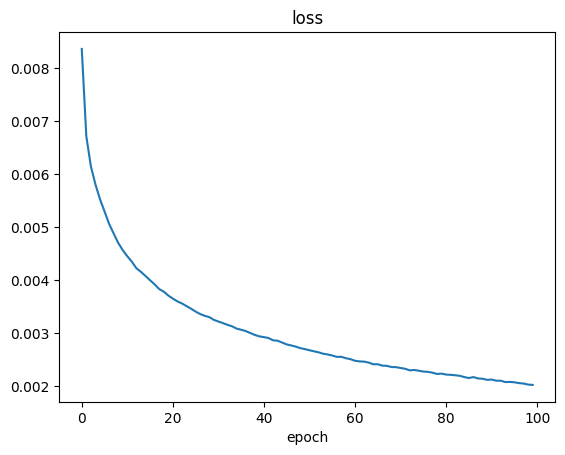

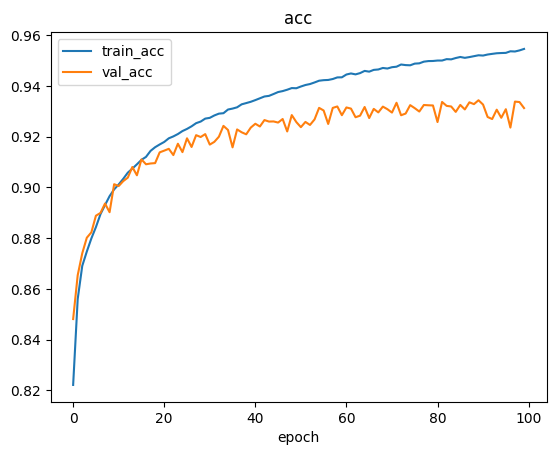

In [24]:
##display loss and acc
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
ax1.plot(np.arange(e+1),loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')

ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

In [25]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path, del_others = True):
    """get best model path by valuation list
    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir
    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    if del_others:
        for f in os.listdir(save_path):
            if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
                os.remove(os.path.join(save_path,f))
    return best_model_path

In [26]:
# save
PATH = 'E:/Roy/Sim Pool/Results/Training/3DConvKAN_Pingan_30.pth'
torch.save(model.state_dict(), PATH)
# reload


best model:epoch_89_acc_0.9344.pth


  0%|          | 0/19219 [00:00<?, ?it/s]

inferring time: 162.82113003730774


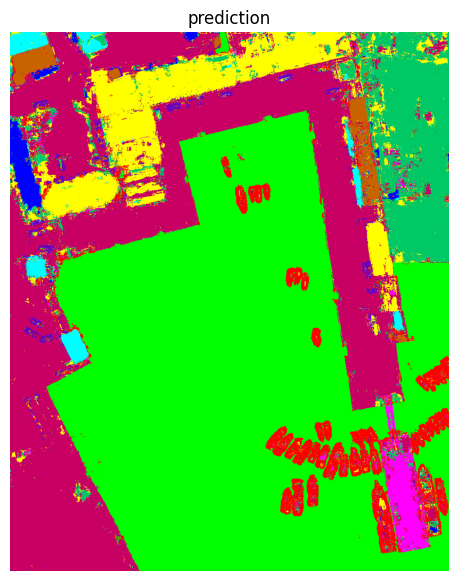

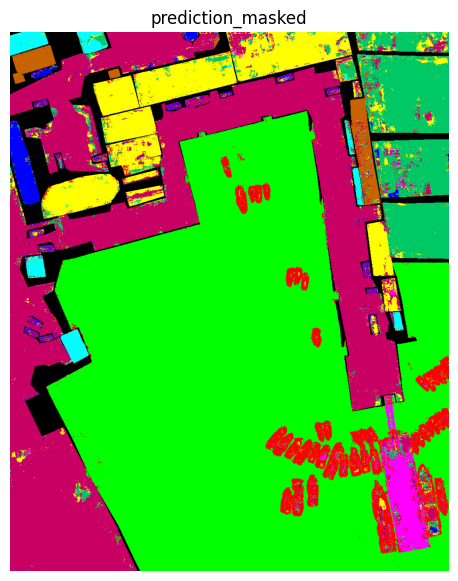

In [27]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH, not run_error)

best_model = model  ## modify to your model

best_model.load_state_dict(torch.load(best_model_path)['state_dict'])
## inference
best_model
best_model.eval()
pred_map = []
infer_st = time.time()

for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
infer_time = time.time() - infer_st


print(f"inferring time: {infer_time}")
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
img_display(classes=pred_map,title='prediction',figsize=(7,7))
img_display(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
# spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
# spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/3DConvKAN_prediction_Pingan.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/3DConvKAN__prediction_masked_Pingan.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [28]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'E:/Roy/Sim Pool/Results/Training/3DConvKAN_Pingan_30_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9336020011604487
AA: 0.8152609404416328
Kappa: 0.90090591692041
training time: 14434.379123687744
inferring time: 162.82113003730774
                              precision    recall  f1-score   support

                        Ship     0.7606    0.7550    0.7578     24468
                    Seawater     0.9916    0.9921    0.9918    289057
                       Trees     0.8690    0.9190    0.8933      4172
 Concrete structure building     0.8429    0.8215    0.8321     44487
               Floating pier     0.7911    0.6729    0.7272     10379
                Brick houses     0.9004    0.8326    0.8652      7043
                Steel houses     0.7474    0.8478    0.7945      6996
     Wharf construction land     0.8279    0.8409    0.8343     41556
                         Car     0.4903    0.5224    0.5059      4054
                        Road     0.9406    0.9484    0.9445    138257

                    accuracy                         0.9336    570469
                   